**Проект заточен на то, чтобы предсказать культуру производственной безопасности (КПБ) каждого работника с помощью методов ML и DL. В конце концов, выбрать наилучшую модель для дальнейшего пользования университетом РГУ нефти и газа имени Губкина.**

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from tqdm import tqdm
import re
import joblib

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from warnings import filterwarnings
filterwarnings('ignore')

sns.set_style('darkgrid')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Просмотр данных и предобработка

In [2]:
file_2020 = pd.read_excel('/kaggle/input/data-assessment/2020.xlsx')
file_2020_addition = pd.read_excel('/kaggle/input/data-assessment/2020_.xlsx')
file_2021 = pd.read_excel('/kaggle/input/data-assessment/2021.xlsx')
file_2022_2023 = pd.read_excel('/kaggle/input/data-assessment/2022_2023.xlsx')

**Сначала приведём все столбцы к одинаковому формату.**

In [3]:
file_2020.columns

Index(['1. Ваш возраст?', '2. Каков Ваш стаж работы по профессии?',
       '3. Укажите уровень занимаемой Вами должности',
       '4. Как Вы считаете, имеется ли возможность выполнять все требования безопасности в процессе Вашей трудовой деятельности?',
       '5. Допускали ли Вы в ходе работы ошибки, которые могли повлечь снижение уровня безопасности? ',
       '6. Возможно ли, по Вашему мнению, в имеющихся условиях трудовой деятельности достичь показателя нулевого травматизма? ',
       '7. Оцените, пожалуйста, по шкале от 1 до 5 общее состояние безопасности Вашей трудовой деятельности.',
       '8. Как Вы оцениваете свой вклад в обеспечении и развитии безопасности компании (в %, от 0 до 100)?',
       '9. Приходилось ли Вам ранее принимать участие в поведенческом аудите безопасности?',
       '10. Готовы ли Вы взять на себя ответственность прервать технологический процесс в случае предаварийной ситуации или при обнаружении небезопасных действий коллег?',
       'КПБ'],
      dtype='

In [4]:
file_2020.columns = file_2020_addition.columns = file_2021.columns = file_2022_2023.columns = [
    'Age',
    'Experience',
    'Post',
    'The ability to perform security',
    'There were security errors',
    'There are risks at work',
    'Security status',
    "Contribution to the company's security",
    'Participation in the audit',
    'Interrupt work in case of danger',
    'КПБ'
]

In [5]:
file_2020.head()

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger,КПБ
0,46,20,Руководитель (администрация),Да,Нет,Да,5.0,75,Да,Да,4.296875
1,37,15,Руководитель (администрация),Да,Нет,Нет,5.0,100,Да,Да,4.828125
2,40,15,Руководитель (администрация),Да,Нет,Да,5.0,100,Нет,Да,4.656250
3,41,19,Линейный руководитель (производственные подраз...,Да,Да,Да,5.0,100,Да,Да,4.625000
4,38,17,Рабочий,Да,Да,Да,5.0,100,Нет,Затрудняюсь ответить,4.593750


In [6]:
data = pd.concat([file_2020, file_2020_addition, file_2021, file_2022_2023], axis=0, ignore_index=True)
assert len(data) == len(file_2020) + len(file_2020_addition) + len(file_2021) + len(file_2022_2023)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30659 entries, 0 to 30658
Data columns (total 11 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     30633 non-null  object 
 1   Experience                              30633 non-null  object 
 2   Post                                    30633 non-null  object 
 3   The ability to perform security         30633 non-null  object 
 4   There were security errors              30633 non-null  object 
 5   There are risks at work                 30633 non-null  object 
 6   Security status                         30633 non-null  float64
 7   Contribution to the company's security  30633 non-null  object 
 8   Participation in the audit              30633 non-null  object 
 9   Interrupt work in case of danger        30633 non-null  object 
 10  КПБ                                     30642 non-null  fl

In [8]:
data.head()

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger,КПБ
0,46,20,Руководитель (администрация),Да,Нет,Да,5.0,75,Да,Да,4.296875
1,37,15,Руководитель (администрация),Да,Нет,Нет,5.0,100,Да,Да,4.828125
2,40,15,Руководитель (администрация),Да,Нет,Да,5.0,100,Нет,Да,4.656250
3,41,19,Линейный руководитель (производственные подраз...,Да,Да,Да,5.0,100,Да,Да,4.625000
4,38,17,Рабочий,Да,Да,Да,5.0,100,Нет,Затрудняюсь ответить,4.593750


In [9]:
len(data)

30659

**Теперь необходимо исключить пропуски из данных.**

In [127]:
data[data.isnull().any(axis=1)]

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger,КПБ
716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.861557
718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.949581
820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data = data.dropna()
len(data)

30633

## Обработка неопределённых значений 

In [11]:
def get_number(x):
    lst = re.findall(r"\d+", x)
    if lst:
        return lst[0]
    else:
        print(x)
        return None

def get_answer(x):
    if x not in ['Да', 'Нет', 'Затрудняюсь ответить']:
        return None
    else:
        return x

In [12]:
for column in ['Age', 'Experience', "Contribution to the company's security"]:
    data[column] = data[column].apply(lambda x: str(x))
    data[column] = data[column].apply(lambda x: get_number(x))

for column in ['The ability to perform security', 'There were security errors', "There are risks at work", 'Participation in the audit', "Interrupt work in case of danger"]:
    data[column] = data[column].apply(lambda x: str(x))
    data[column] = data[column].apply(lambda x: get_answer(x))

И
Сорок
год
ст.инспектор АХО
Год
Полтора года.
Е
Згода
З
Десять лет
Нет коментариев
Полгода 
Менее года
З
Полгода
Старший мастер
Некорректно поставлен вопрос
затрудняюсь ответить
Некорректно поставлен вопрос
затрудняюсь ответить
*
Не знаю
затрудняюсь ответить
К
💯
Наивысший
Безопасность превыше всенго
Затрудняюсь ответить
Затрудняюсь ответить.
-
Затрудняюсь
💯 
В полной мере
Отлично
💯
Затрудняюсь 
Никак
Хороший 
Никак 


In [13]:
data[data.isnull().any(axis=1)]

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger,КПБ
145,41,21,Руководитель (администрация),Да,Нет,Да,5.0,None,Нет,Да,4.218750
245,41,None,Рабочий,Нет,Нет,Затрудняюсь ответить,4.0,70,Нет,Да,3.671875
421,51,26,Руководитель (администрация),Нет,Да,Нет,4.0,None,Да,Нет,3.156250
948,41,21,Руководитель (администрация),Да,Нет,Да,5.0,None,Нет,Да,4.218750
983,51,26,Руководитель (администрация),Нет,Да,Нет,4.0,None,Да,Нет,3.156250
1845,60,None,Специалист (администрация),Затрудняюсь ответить,Нет,Да,5.0,90,Нет,Да,3.546875
1998,45,25,Специалист (производственные подразделения всп...,Да,Нет,Затрудняюсь ответить,5.0,None,Нет,Нет,3.718750
3842,44,6,Рабочий,Да,Нет,Затрудняюсь ответить,3.0,None,Нет,Нет,3.984375
3982,45,None,Рабочий,Да,Нет,Да,5.0,90,Да,Да,4.156250
4468,40,None,Рабочий,Затрудняюсь ответить,Нет,Затрудняюсь ответить,3.0,10,Нет,Затрудняюсь ответить,3.406250


In [14]:
data = data.dropna()
len(data)

30597

In [15]:
for column in ['Age', 'Experience', 'Security status', "Contribution to the company's security"]:
    data[column] = data[column].astype('int64')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30597 entries, 0 to 30658
Data columns (total 11 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     30597 non-null  int64  
 1   Experience                              30597 non-null  int64  
 2   Post                                    30597 non-null  object 
 3   The ability to perform security         30597 non-null  object 
 4   There were security errors              30597 non-null  object 
 5   There are risks at work                 30597 non-null  object 
 6   Security status                         30597 non-null  int64  
 7   Contribution to the company's security  30597 non-null  int64  
 8   Participation in the audit              30597 non-null  object 
 9   Interrupt work in case of danger        30597 non-null  object 
 10  КПБ                                     30597 non-null  float64

In [17]:
data.columns

Index(['Age', 'Experience', 'Post', 'The ability to perform security',
       'There were security errors', 'There are risks at work',
       'Security status', 'Contribution to the company's security',
       'Participation in the audit', 'Interrupt work in case of danger',
       'КПБ'],
      dtype='object')

## Подсчёт уникальных значений столбцов для эмбеддингов 

In [18]:
print(data['Post'].nunique())
print(data['The ability to perform security'].nunique())
print(data['There were security errors'].nunique())
print(data['There are risks at work'].nunique())
print(data['Participation in the audit'].nunique())
print(data['Interrupt work in case of danger'].nunique())

8
3
3
3
2
3


# Визуализация и работа с выбросами с помощью IQR

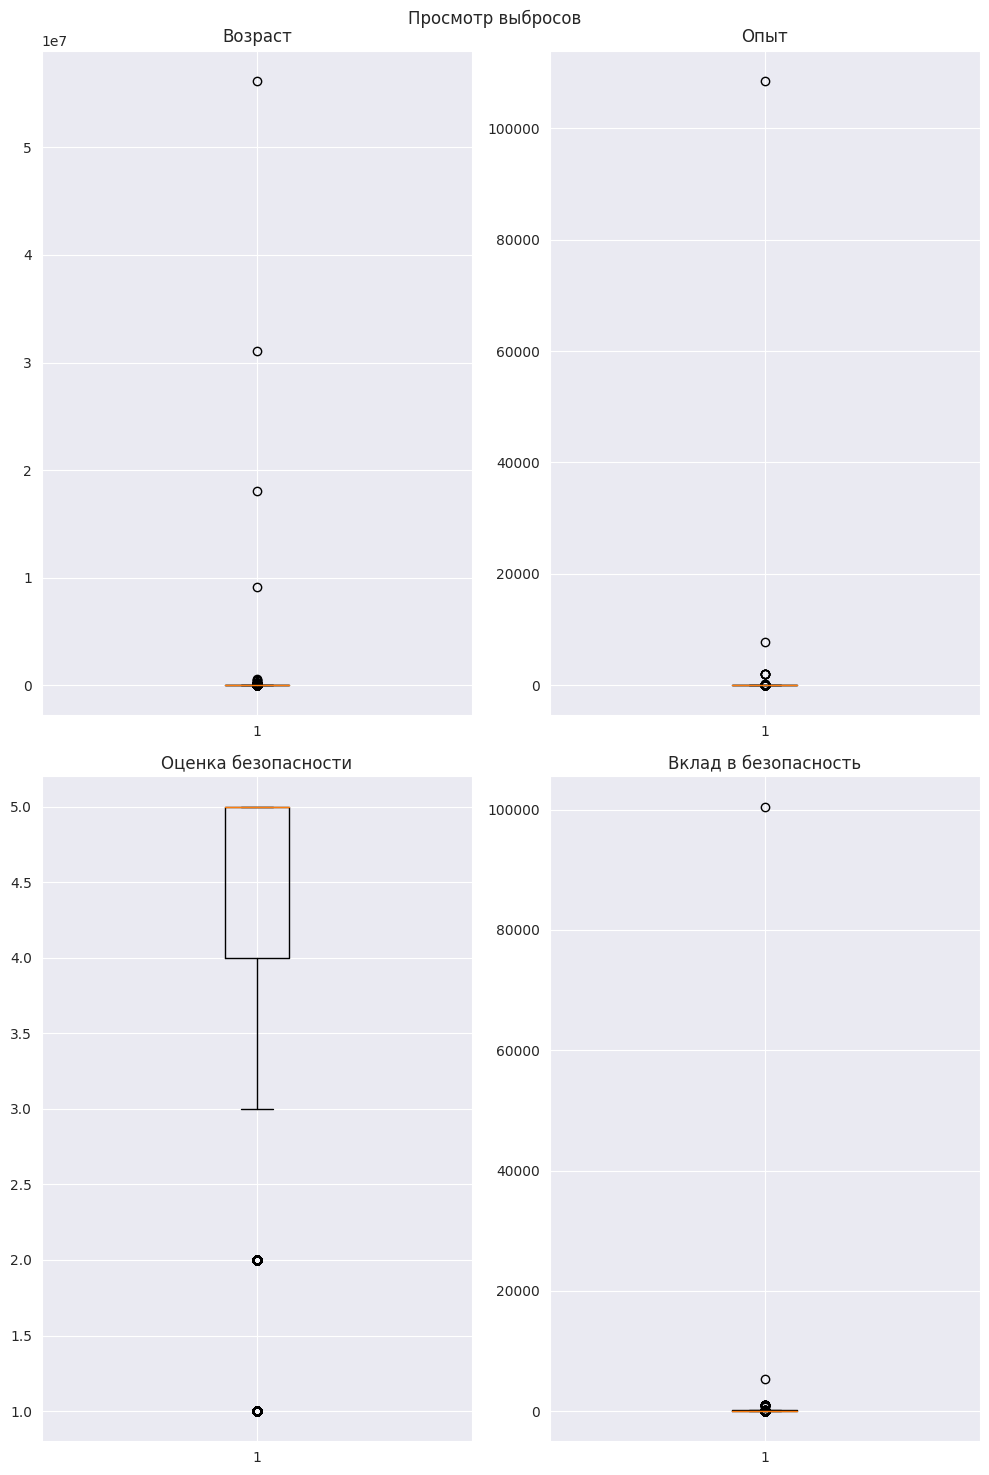

In [19]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Просмотр выбросов')
fig.set_figheight(15)
fig.set_figwidth(10)
axs[0, 0].boxplot(data['Age'])
axs[0, 0].set_title('Возраст')
axs[0, 1].boxplot(data['Experience'])
axs[0, 1].set_title('Опыт')
axs[1, 0].boxplot(data['Security status'])
axs[1, 0].set_title('Оценка безопасности')
axs[1, 1].boxplot(data["Contribution to the company's security"])
axs[1, 1].set_title('Вклад в безопасность')
fig.tight_layout()

In [20]:
for column in ['Age', 'Experience', "Contribution to the company's security", "Security status"]:
    q1, q3 = data[column].quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    data = data[(data[column] >= low) & (data[column] <= high)]
len(data)

28108

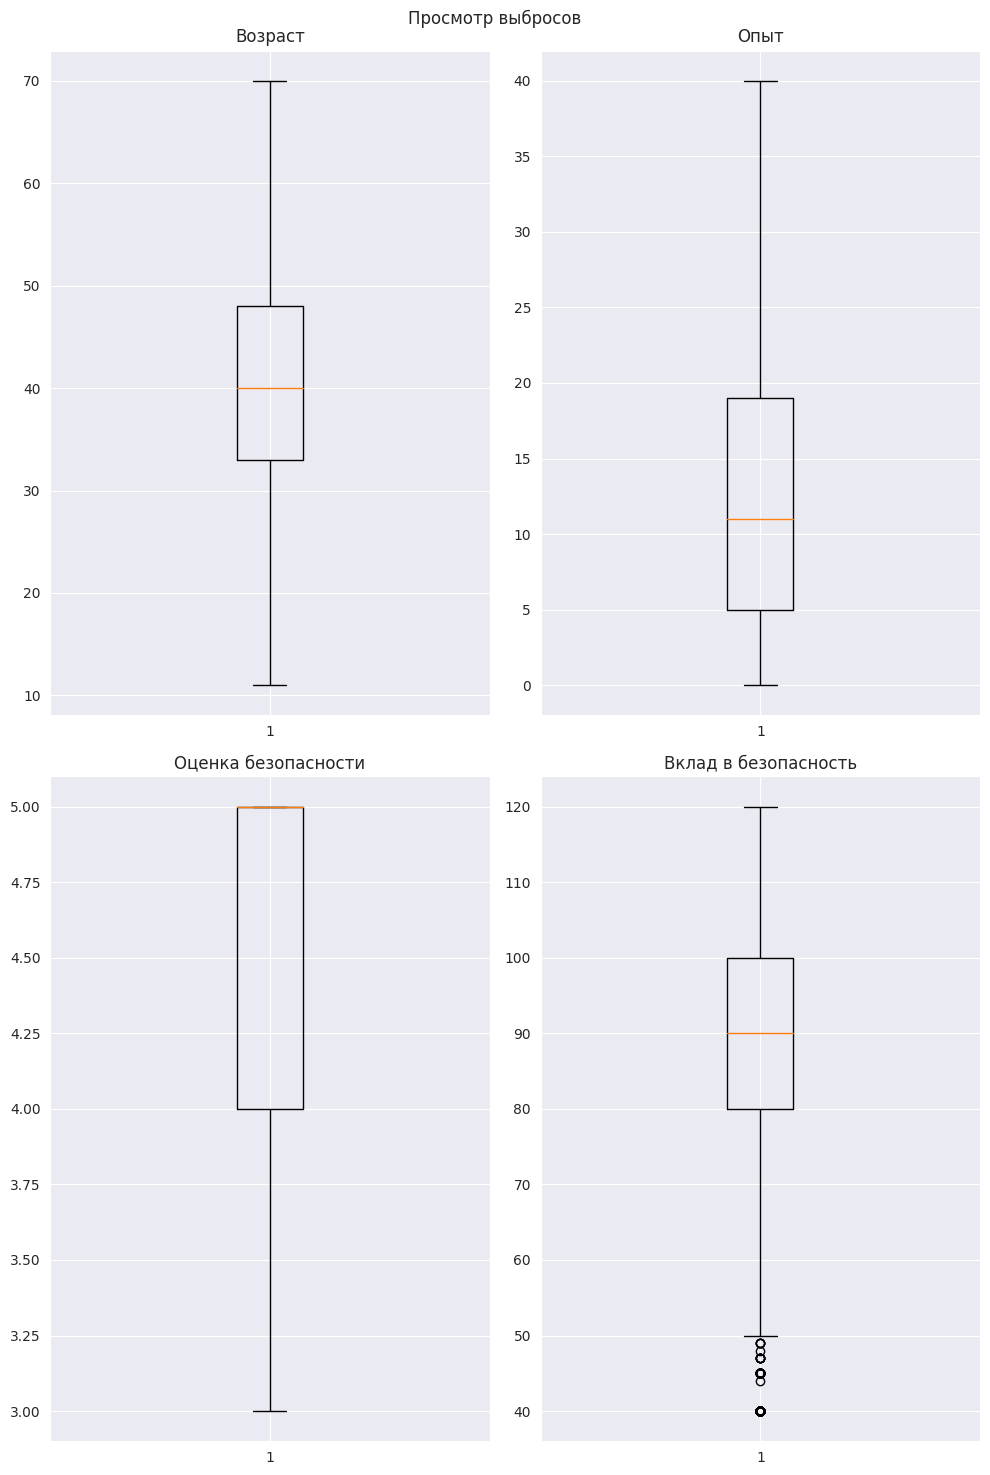

In [21]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Просмотр выбросов')
fig.set_figheight(15)
fig.set_figwidth(10)
axs[0, 0].boxplot(data['Age'])
axs[0, 0].set_title('Возраст')
axs[0, 1].boxplot(data['Experience'])
axs[0, 1].set_title('Опыт')
axs[1, 0].boxplot(data['Security status'])
axs[1, 0].set_title('Оценка безопасности')
axs[1, 1].boxplot(data["Contribution to the company's security"])
axs[1, 1].set_title('Вклад в безопасность')
fig.tight_layout()

## Приведение распределения целевой переменной к нормальному

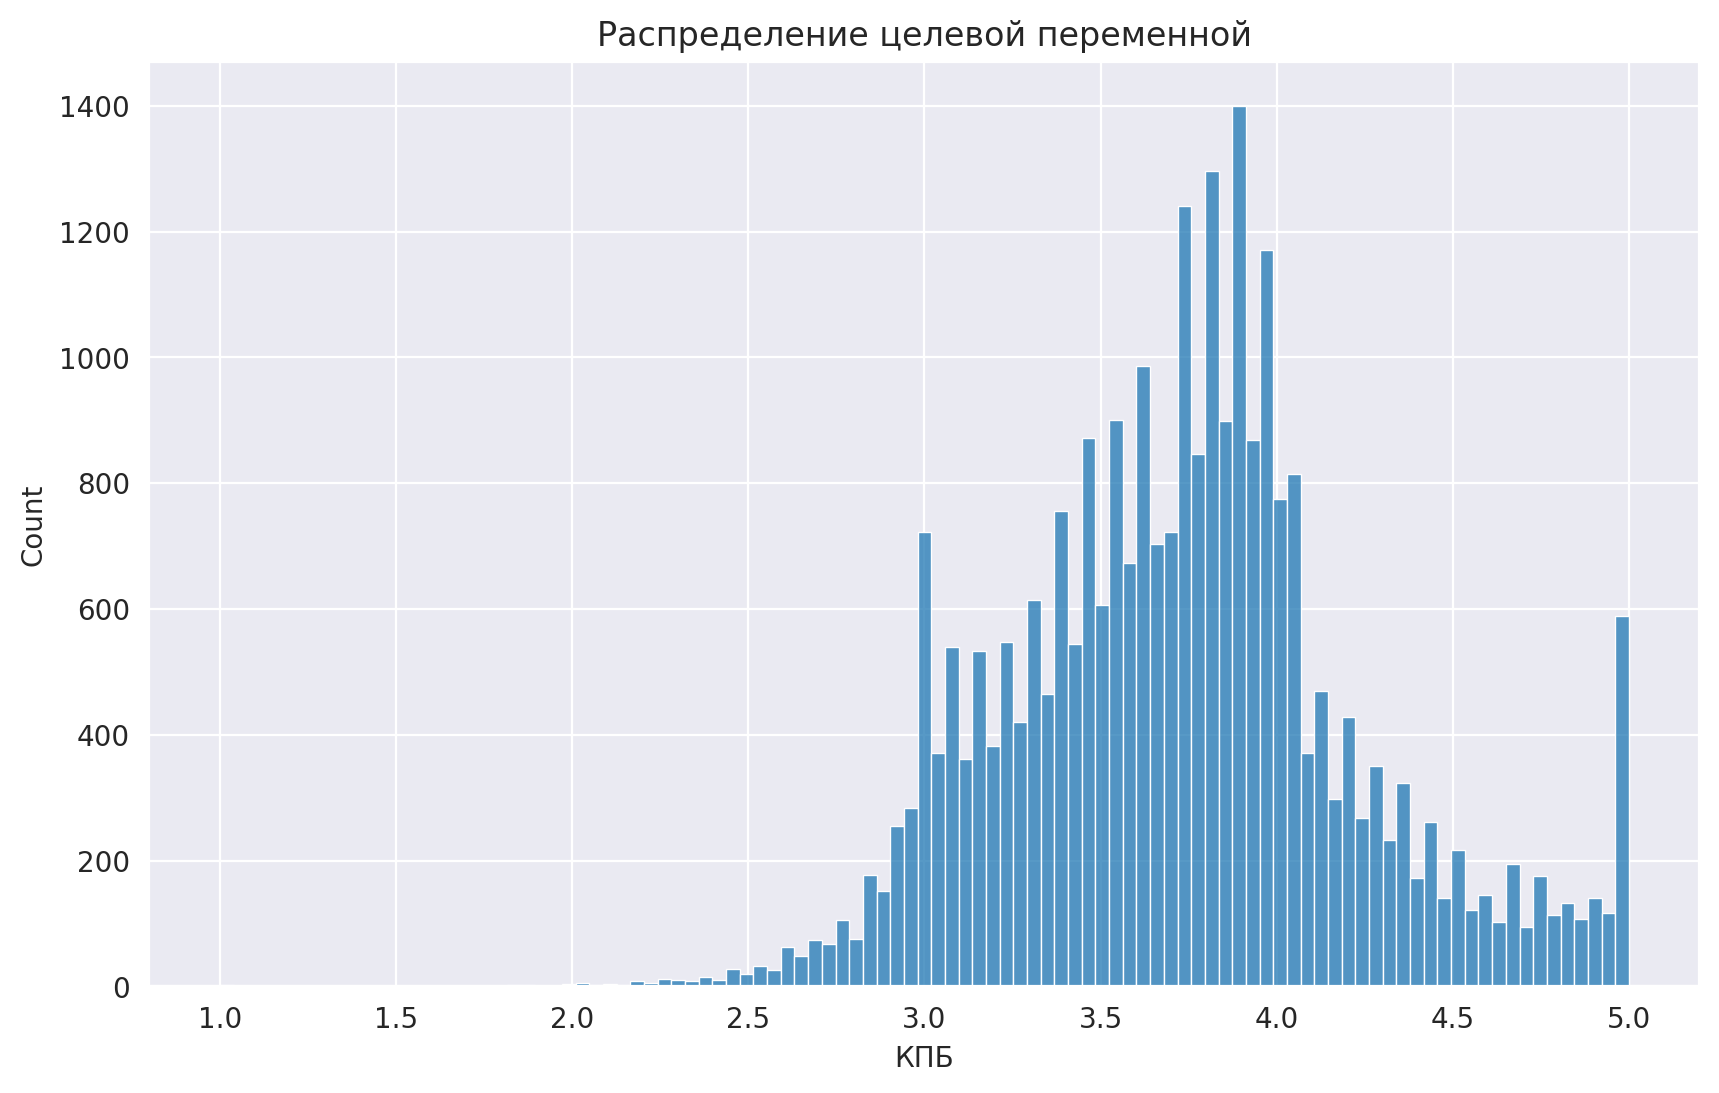

In [22]:
plt.figure(figsize=(10,6), dpi=200)
sns.histplot(data=data, x='КПБ')
plt.title('Распределение целевой переменной');

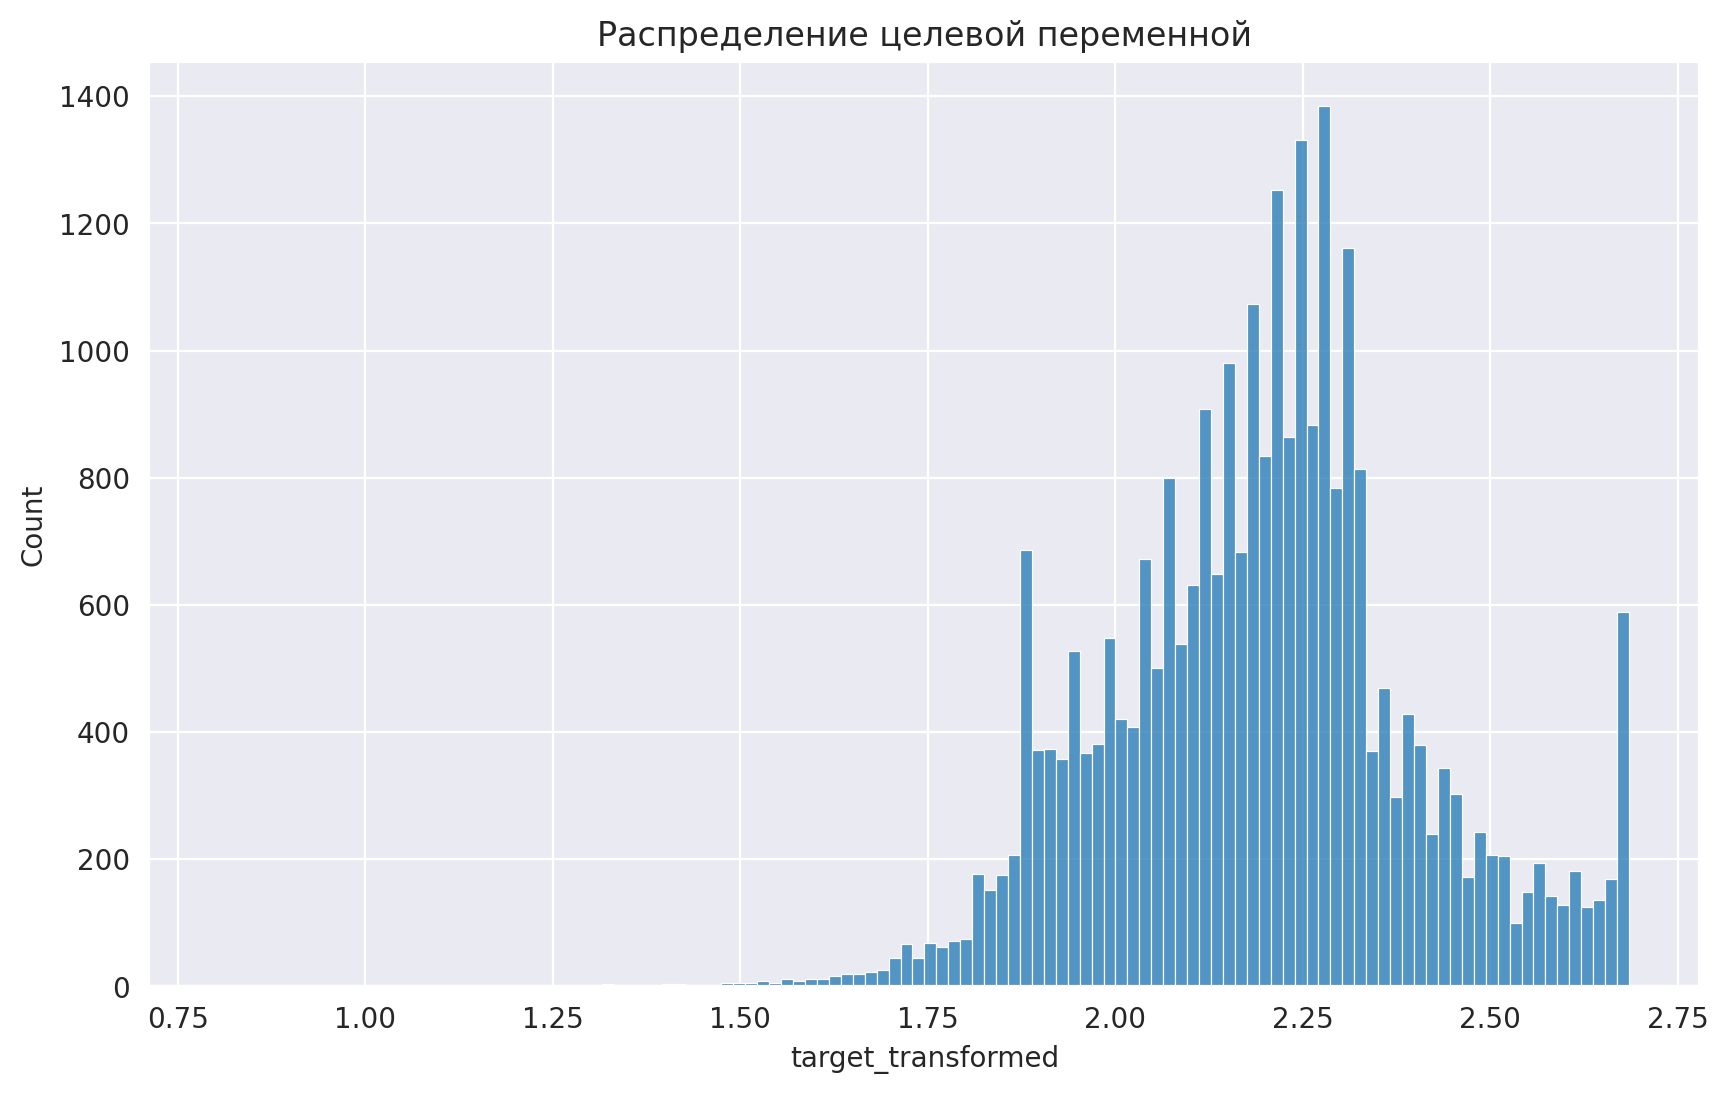

In [24]:
data['target_transformed'], lmda = boxcox(data['КПБ'] + 1)
plt.figure(figsize=(10,6), dpi=200)
sns.histplot(data=data, x='target_transformed')
plt.title('Распределение целевой переменной');

In [25]:
print(f'Коэффициент преобразования: {lmda}')

Коэффициент преобразования: 0.4245912219216052


# Подготовка данных к простым моделям 

In [26]:
X = data.drop(['КПБ', 'target_transformed'], axis=1)
y = data[['target_transformed']]

In [27]:
y.dtypes

target_transformed    float64
dtype: object

In [28]:
X.dtypes

Age                                        int64
Experience                                 int64
Post                                      object
The ability to perform security           object
There were security errors                object
There are risks at work                   object
Security status                            int64
Contribution to the company's security     int64
Participation in the audit                object
Interrupt work in case of danger          object
dtype: object

In [29]:
categorical_columns = ['Post', 'The ability to perform security', 'There were security errors',
                      'There are risks at work', 'Participation in the audit',
                      'Interrupt work in case of danger']
int_columns = ['Age', 'Experience', "Contribution to the company's security"]
X[int_columns] = X[int_columns].astype('int32')
num_columns = ['Age', 'Experience', 'Security status', "Contribution to the company's security"]

In [30]:
assert len(categorical_columns) + len(num_columns) == 10

In [31]:
def encode(df, cols):
    encode_dict = {}
    for col in cols:
        print(f'{col}: преобразовалась')
        label_encoder = LabelEncoder()
        label_encoder = label_encoder.fit(df[col].values) 
        df[col] = label_encoder.transform(df[col].values)
        encode_dict[col] = label_encoder
    return df, encode_dict

X_cat, encode_dict = encode(X, categorical_columns)

Post: преобразовалась
The ability to perform security: преобразовалась
There were security errors: преобразовалась
There are risks at work: преобразовалась
Participation in the audit: преобразовалась
Interrupt work in case of danger: преобразовалась


In [32]:
encode_dict

{'Post': LabelEncoder(),
 'The ability to perform security': LabelEncoder(),
 'There were security errors': LabelEncoder(),
 'There are risks at work': LabelEncoder(),
 'Participation in the audit': LabelEncoder(),
 'Interrupt work in case of danger': LabelEncoder()}

In [33]:
joblib.dump(encode_dict, 'encoders.save')

['encoders.save']

In [34]:
scaler_dict = {}
for col in num_columns:
    scaler = StandardScaler()
    scaler_dict[col] = scaler.fit(X[col].values.reshape(-1, 1))
    X[col] = scaler_dict[col].transform(X[col].values.reshape(-1, 1))

In [35]:
X.head()

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger
0,0.588273,0.816691,3,0,2,0,0.798291,-0.684070,0,0
1,-0.375727,0.258615,3,0,2,2,0.798291,0.963475,0,0
2,-0.054394,0.258615,3,0,2,0,0.798291,0.963475,1,0
3,0.052717,0.705076,0,0,0,0,0.798291,0.963475,0,0
4,-0.268616,0.481846,2,0,0,0,0.798291,0.963475,1,1


In [36]:
scaler_dict

{'Age': StandardScaler(),
 'Experience': StandardScaler(),
 'Security status': StandardScaler(),
 "Contribution to the company's security": StandardScaler()}

In [39]:
joblib.dump(scaler_dict, 'scalers.save')

['scalers.save']

## Рассмотрим корреляцию признаков

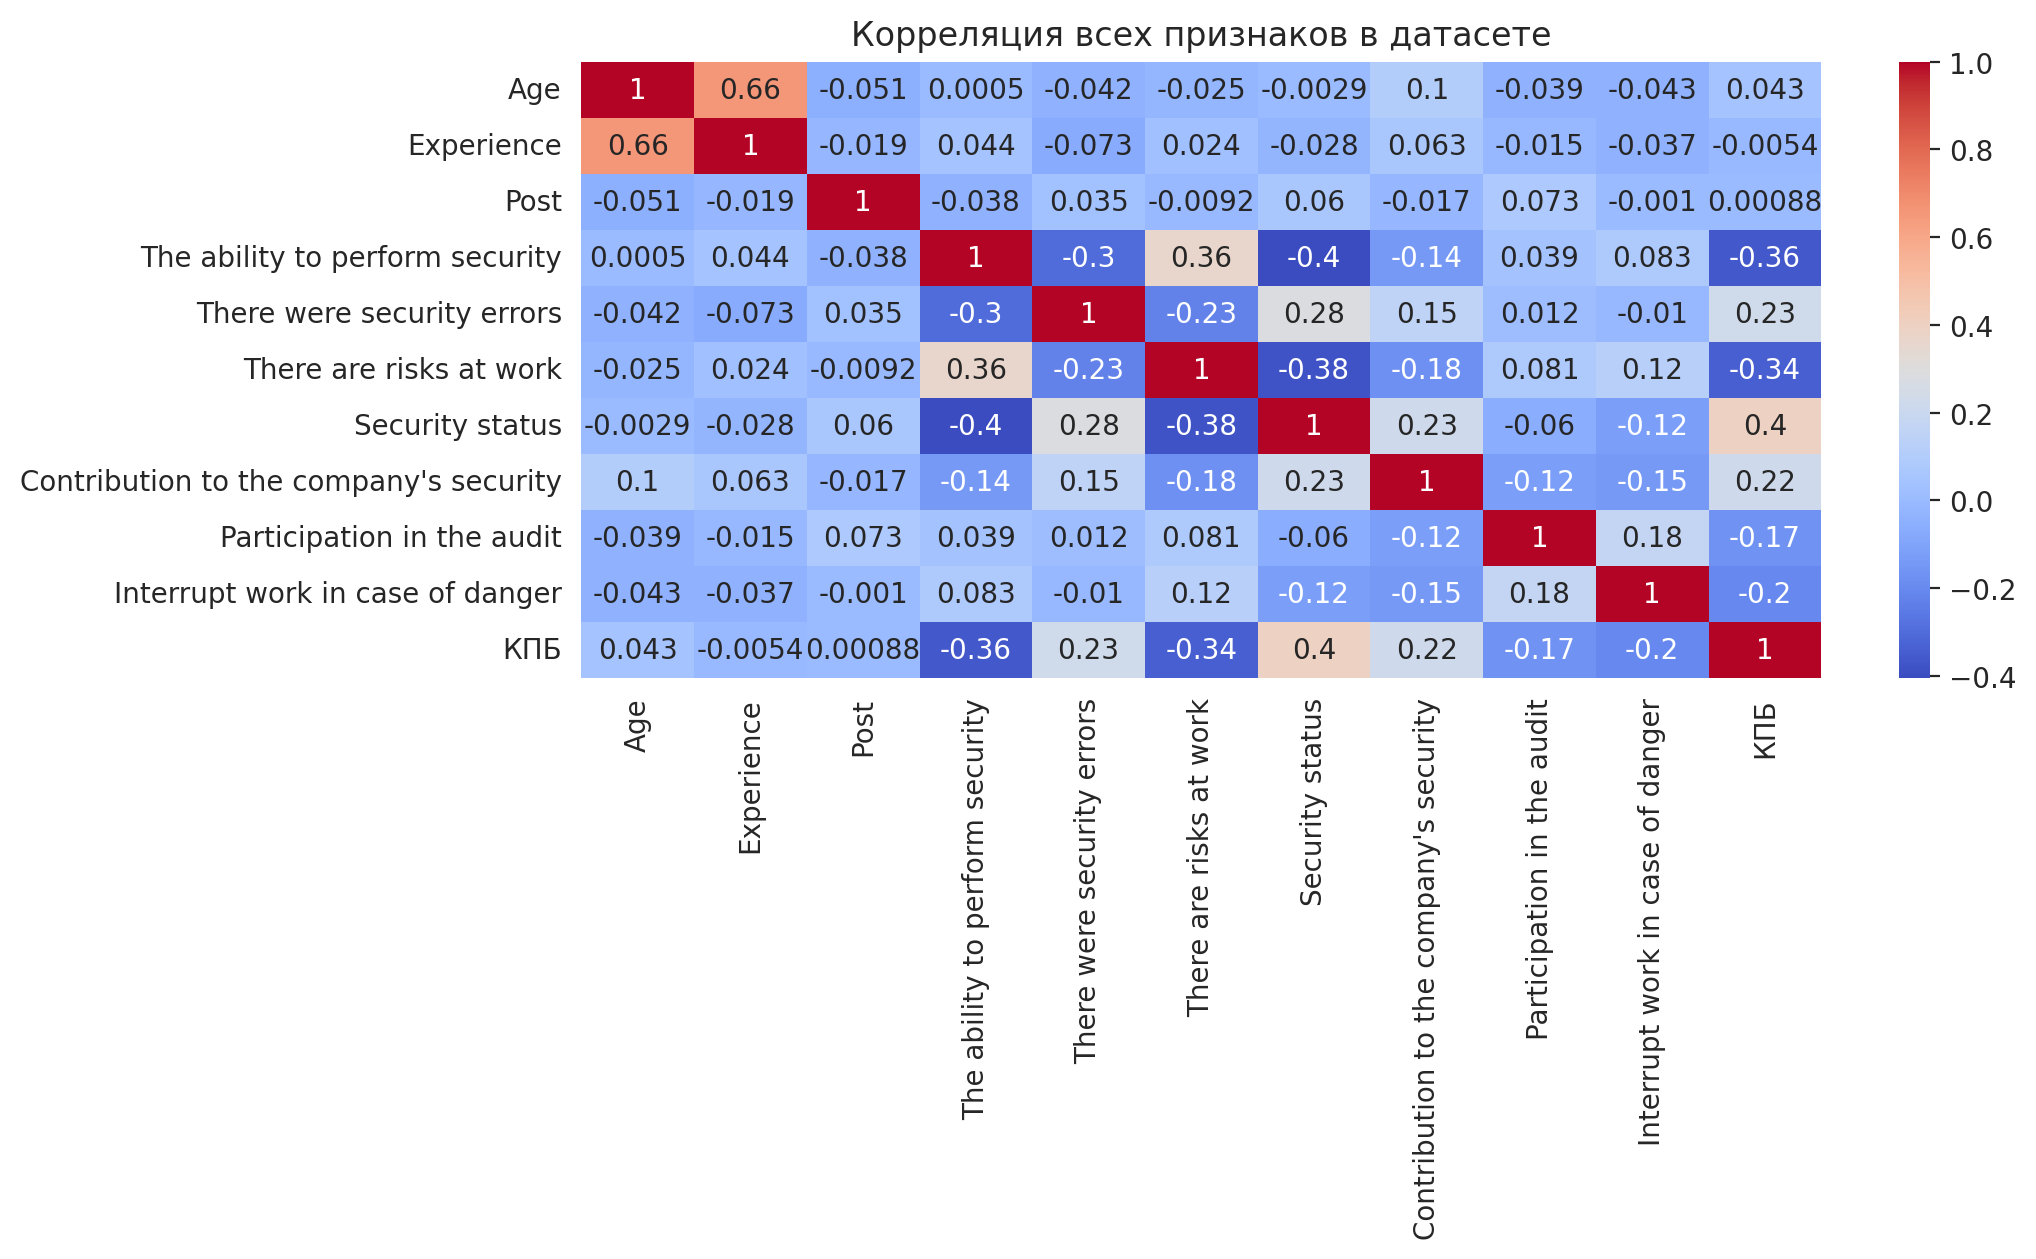

In [318]:
plt.figure(figsize=(10, 4), dpi=200)
sns.heatmap(pd.concat([X, y], axis=1).corr(), cmap='coolwarm', annot=True);
plt.title('Корреляция всех признаков в датасете');

## Разделение выборки

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

In [31]:
X_train.head()

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger
19015,-1.125505,-0.522691,6,2,0,0,-0.776663,-1.474892,0,1
30443,1.552273,-1.080766,3,0,2,2,-0.776663,-2.331616,1,0
23267,-0.375727,-0.522691,0,0,2,0,0.798291,0.633966,1,0
12533,-0.482838,0.593461,2,1,1,1,-0.776663,0.897574,1,0
8036,0.481162,0.816691,4,0,2,0,0.798291,0.633966,0,0


## Отбор признаков с помощью случайного леса 

In [334]:
rf_importance = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_importance.fit(X_train, y_train)
importances = rf_importance.feature_importances_

<ipython-input-334-e320f24f4001>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_importance.fit(X_train, y_train)


<Figure size 1200x800 with 0 Axes>

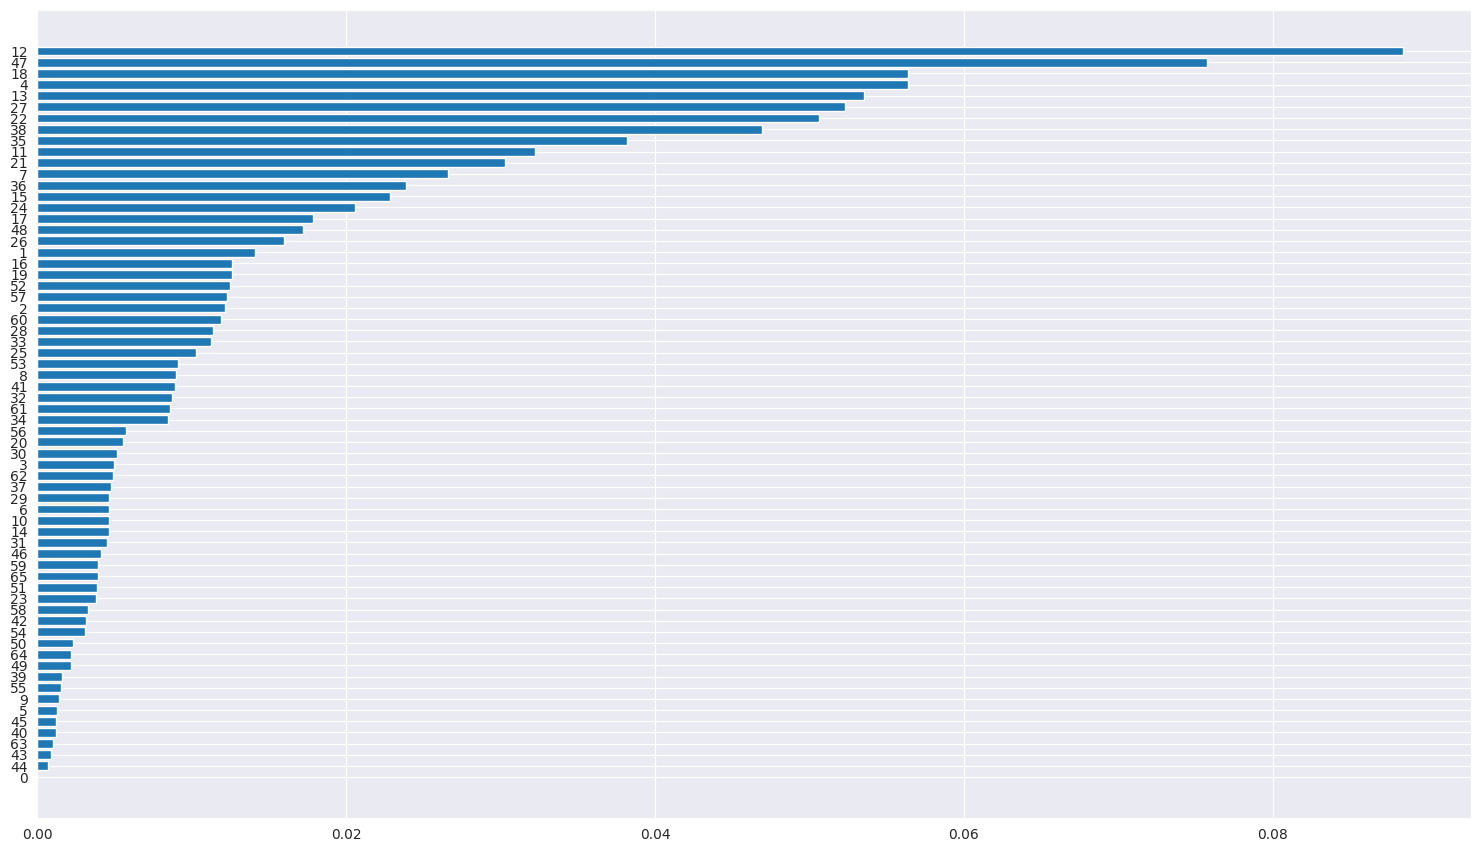

In [337]:
plt.figure(figsize=(12,8))
indices = np.argsort(importances)

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

In [361]:
X_train = X_train.drop(indices[:51],axis=1)

# Baseline модель

In [31]:
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_train, y_train, train_size=0.9, \
                                                                     random_state=42)

base_model = LinearRegression()
base_model.fit(X_train_base, y_train_base)
preds = base_model.predict(X_val_base)

print(f'Вычисленное отклонение rmse: {np.sqrt(mean_squared_error(y_val_base, preds))}')

Вычисленное отклонение rmse: 0.18006092921609185


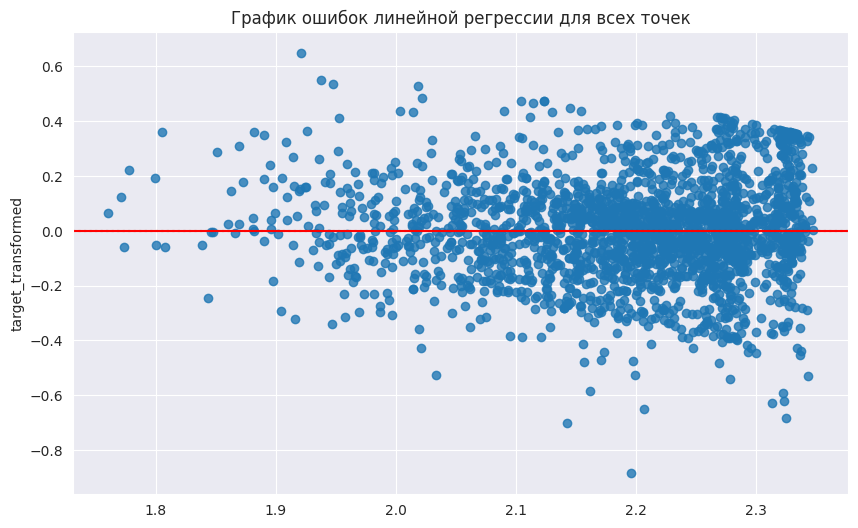

In [32]:
plt.figure(figsize=(10,6), dpi=100)
sns.residplot(x=preds, y=y_val_base);
plt.axhline(y=0, color='r');
plt.title('График ошибок линейной регрессии для всех точек');

# XGBoost, Catboost

In [29]:
def training_model_with_randomsearch(model, X_train, y_train, X_test, y_test, params_dict):
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params_dict,
        n_iter=10,
        cv=3,
        scoring='neg_mean_squared_error', 
        verbose=1
    )
    random_search.fit(X_train, y_train)
    preds = random_search.predict(X_test)
    print("Лучшие гиперпараметры:", random_search.best_params_)
    print(f'Вычисленное значение rmse: {np.sqrt(mean_squared_error(y_test, preds))}')

In [30]:
def training_model_with_gridsearch(model, X_train, y_train, X_test, y_test, params_dict):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params_dict,
        cv=3,
        scoring='neg_mean_squared_error',
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    preds = grid_search.predict(X_test)
    print("Лучшие гиперпараметры:", grid_search.best_params_)
    print(f'Вычисленное значение rmse: {np.sqrt(mean_squared_error(y_test, preds))}')

**XGBoost**

In [ ]:
params_dict = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.5, 0.7, 0.8, 0.9]
}

xgb = XGBRegressor(tree_method='gpu_hist', random_state=42)
training_model_with_randomsearch(xgb, X_train_base, y_train_base, X_val_base, y_val_base, params_dict)

In [34]:
params_dict = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5],
    'min_child_weight': [4, 5, 6],
    'subsample': [0.75, 0.8, 0.85]
}

xgb = XGBRegressor(tree_method='gpu_hist', random_state=42)
training_model_with_gridsearch(xgb, X_train, y_train, X_test, y_test, params_dict)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Лучшие гиперпараметры: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
Вычисленное значение rmse: 0.17100096680930743


**Catboost**

In [34]:
params = {
    'depth': [7, 8, 9],
    'learning_rate': [0.05, 0.04],
    'iterations': [400, 500],
    'l2_leaf_reg': [8, 9, 10],
}
cat = CatBoostRegressor(task_type='GPU', verbose=0)

In [33]:
training_model_with_randomsearch(cat, X_train, y_train, X_test, y_test, params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие гиперпараметры: {'learning_rate': 0.05, 'l2_leaf_reg': 9, 'iterations': 500, 'depth': 8}
Вычисленное значение rmse: 0.1708571117558914


In [34]:
cat = CatBoostRegressor(task_type='GPU', verbose=0, learning_rate=0.05, l2_leaf_reg=11, iterations=500, depth=10)
cat.fit(X_train_base, y_train_base)
preds = cat.predict(X_val_base)
print(f'Вычисленное значение rmse: {np.sqrt(mean_squared_error(y_val_base, preds))}')
print(f'Вычисленное значение R^2: {r2_score(y_val_base, preds)}')

Вычисленное значение rmse: 0.17560324906226016
Вычисленное значение R^2: 0.2810972982060578


In [35]:
training_model_with_gridsearch(cat, X_train, y_train, X_test, y_test, params)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Лучшие гиперпараметры: {'depth': 9, 'iterations': 500, 'l2_leaf_reg': 8, 'learning_rate': 0.05}
Вычисленное значение rmse: 0.170870629041348


# Подготовка данных к нейронке

In [87]:
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=42)

In [54]:
class MyDataset(Dataset):
    def __init__(self, df, num_cols, cat_cols, targets):
        self.num_data = df[num_cols]
        self.cat_data = df[cat_cols]
        self.targets = targets

    def __len__(self):
        return len(self.num_data) 

    def __getitem__(self, idx):
        return torch.FloatTensor(self.num_data.iloc[idx].values), torch.LongTensor(self.cat_data.iloc[idx].values), (self.targets.iloc[idx].values).astype('float32')

In [22]:
train_dataset = MyDataset(X_train, num_columns, categorical_columns, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = MyDataset(X_test, num_columns, categorical_columns, y_test)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Архитектура нейросети

**Определяем количество эмбеддингов.**

In [48]:
cat_dims = [X[col].nunique() for col in categorical_columns]
cat_embs = [(dim, min(50,(dim+1)//2)) for dim in cat_dims]
cat_embs

[(8, 4), (3, 2), (3, 2), (3, 2), (2, 1), (3, 2)]

In [55]:
class MyModel(nn.Module):
    def __init__(self, input_shape, embeddings_shape):
        super(MyModel, self).__init__()
        self.relu = nn.ReLU()

        # Создание эмбеддингов
        self.embeddings = nn.ModuleList(nn.Embedding(dim1,dim2) for dim1, dim2 in embeddings_shape)
        len_emb = sum([dim2 for dim1, dim2 in embeddings_shape])

        # Полносвязные слои с дропаутом и пакетной нормализацией
        self.linear_1 = nn.Linear(input_shape + len_emb, 128)
        self.dropout1 = nn.Dropout(0.35)

        self.bn1 = nn.BatchNorm1d(128)
        
        self.linear_2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.35)

        self.bn2 = nn.BatchNorm1d(64)
        
        self.linear_3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(0.35) 

        self.bn3 = nn.BatchNorm1d(32)
        
        self.linear_4 = nn.Linear(32, 16)
        self.dropout4 = nn.Dropout(0.35)

        self.bn4 = nn.BatchNorm1d(16)
        
        self.linear_5 = nn.Linear(16, 1)
        
    def forward(self, num_batch, cat_batch):
        # Работаем с категориальными данными 
        x_cat = [embedding_layer(cat_batch[:, i]) for i, embedding_layer in enumerate(self.embeddings)]
        x_cat = torch.cat(x_cat, 1)
        x = torch.cat([x_cat, num_batch], 1)

        # Основной проход
        x = self.relu(self.linear_1(x))
        x = self.dropout1(x)
        
        x = self.bn1(x)
        
        x = self.relu(self.linear_2(x))
        x = self.dropout2(x)
        
        x = self.bn2(x)
        
        x = self.relu(self.linear_3(x))
        x = self.dropout3(x)
        
        x = self.bn3(x)
        
        x = self.relu(self.linear_4(x))
        x = self.dropout4(x)
        
        x = self.bn4(x)
        
        out = self.linear_5(x)
        return out

In [25]:
model = MyModel(len(num_columns), cat_embs).to(device)
print(model)

MyModel(
  (relu): ReLU()
  (embeddings): ModuleList(
    (0): Embedding(8, 4)
    (1-3): 3 x Embedding(3, 2)
    (4): Embedding(2, 1)
    (5): Embedding(3, 2)
  )
  (linear_1): Linear(in_features=17, out_features=128, bias=True)
  (dropout1): Dropout(p=0.35, inplace=False)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.35, inplace=False)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_3): Linear(in_features=64, out_features=32, bias=True)
  (dropout3): Dropout(p=0.35, inplace=False)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_4): Linear(in_features=32, out_features=16, bias=True)
  (dropout4): Dropout(p=0.35, inplace=False)
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_5): Linear(in_features=16, 

In [26]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_losses, val_losses = [], []
y_preds, y_trues = [], []
epochs = 30
for epoch in range(epochs):
    # ТРЕНИРОВКА
    model.train()
    train_loop = tqdm(train_loader)
    train_loss_epoch = 0
    for num_data, cat_data, targets in train_loop:
        num_data = num_data.to(device)
        cat_data = cat_data.to(device)
        targets = targets.to(device)
        
        # прямой проход
        preds = model(num_data, cat_data)
        loss = criterion(preds, targets)
        train_loss_epoch += loss.item()
        

        # обратное распространение
        opt.zero_grad()
        loss.backward()
        opt.step()

    mean_train_loss = train_loss_epoch / len(train_loader)
    train_losses.append(mean_train_loss)
    print(f"Epoch {epoch+1}/{epochs}, train_loss: {mean_train_loss:.4f}")

    # ВАЛИДАЦИЯ
    model.eval()
    val_loop = tqdm(val_loader)
    val_loss_epoch = 0
    with torch.no_grad():
        for num_data, cat_data, targets in val_loop:
            num_data = num_data.to(device)
            cat_data = cat_data.to(device)
            targets = targets.to(device)

            # оценка
            preds = model(num_data, cat_data)
            loss = criterion(preds, targets)
            val_loss_epoch += loss.item()

            y_preds.append(preds)
            y_trues.append(targets)

    mean_val_loss = val_loss_epoch / len(val_loader)
    val_losses.append(mean_val_loss)
    print(f"Epoch {epoch+1}/{epochs}, val_loss: {mean_val_loss:.4f}")

100%|██████████| 396/396 [00:05<00:00, 75.12it/s]


Epoch 1/30, train_loss: 2.1765


100%|██████████| 44/44 [00:00<00:00, 110.21it/s]


Epoch 1/30, val_loss: 0.0838


100%|██████████| 396/396 [00:04<00:00, 86.23it/s]


Epoch 2/30, train_loss: 0.2273


100%|██████████| 44/44 [00:00<00:00, 112.93it/s]


Epoch 2/30, val_loss: 0.0387


100%|██████████| 396/396 [00:04<00:00, 86.29it/s]


Epoch 3/30, train_loss: 0.0978


100%|██████████| 44/44 [00:00<00:00, 112.54it/s]


Epoch 3/30, val_loss: 0.0348


100%|██████████| 396/396 [00:04<00:00, 87.03it/s]


Epoch 4/30, train_loss: 0.0563


100%|██████████| 44/44 [00:00<00:00, 113.73it/s]


Epoch 4/30, val_loss: 0.0330


100%|██████████| 396/396 [00:04<00:00, 83.49it/s]


Epoch 5/30, train_loss: 0.0425


100%|██████████| 44/44 [00:00<00:00, 111.55it/s]


Epoch 5/30, val_loss: 0.0327


100%|██████████| 396/396 [00:04<00:00, 86.04it/s]


Epoch 6/30, train_loss: 0.0383


100%|██████████| 44/44 [00:00<00:00, 112.98it/s]


Epoch 6/30, val_loss: 0.0318


100%|██████████| 396/396 [00:04<00:00, 85.76it/s]


Epoch 7/30, train_loss: 0.0364


100%|██████████| 44/44 [00:00<00:00, 111.81it/s]


Epoch 7/30, val_loss: 0.0317


100%|██████████| 396/396 [00:04<00:00, 86.51it/s]


Epoch 8/30, train_loss: 0.0352


100%|██████████| 44/44 [00:00<00:00, 113.24it/s]


Epoch 8/30, val_loss: 0.0315


100%|██████████| 396/396 [00:04<00:00, 85.11it/s]


Epoch 9/30, train_loss: 0.0349


100%|██████████| 44/44 [00:00<00:00, 112.82it/s]


Epoch 9/30, val_loss: 0.0314


100%|██████████| 396/396 [00:04<00:00, 86.40it/s]


Epoch 10/30, train_loss: 0.0340


100%|██████████| 44/44 [00:00<00:00, 111.47it/s]


Epoch 10/30, val_loss: 0.0309


100%|██████████| 396/396 [00:04<00:00, 83.41it/s]


Epoch 11/30, train_loss: 0.0340


100%|██████████| 44/44 [00:00<00:00, 110.83it/s]


Epoch 11/30, val_loss: 0.0305


100%|██████████| 396/396 [00:04<00:00, 85.96it/s]


Epoch 12/30, train_loss: 0.0335


100%|██████████| 44/44 [00:00<00:00, 112.60it/s]


Epoch 12/30, val_loss: 0.0305


100%|██████████| 396/396 [00:04<00:00, 85.78it/s]


Epoch 13/30, train_loss: 0.0336


100%|██████████| 44/44 [00:00<00:00, 112.03it/s]


Epoch 13/30, val_loss: 0.0301


100%|██████████| 396/396 [00:04<00:00, 85.68it/s]


Epoch 14/30, train_loss: 0.0332


100%|██████████| 44/44 [00:00<00:00, 111.99it/s]


Epoch 14/30, val_loss: 0.0304


100%|██████████| 396/396 [00:04<00:00, 85.27it/s]


Epoch 15/30, train_loss: 0.0330


100%|██████████| 44/44 [00:00<00:00, 111.72it/s]


Epoch 15/30, val_loss: 0.0305


100%|██████████| 396/396 [00:04<00:00, 86.25it/s]


Epoch 16/30, train_loss: 0.0328


100%|██████████| 44/44 [00:00<00:00, 112.26it/s]


Epoch 16/30, val_loss: 0.0298


100%|██████████| 396/396 [00:04<00:00, 83.10it/s]


Epoch 17/30, train_loss: 0.0327


100%|██████████| 44/44 [00:00<00:00, 110.24it/s]


Epoch 17/30, val_loss: 0.0299


100%|██████████| 396/396 [00:04<00:00, 84.20it/s]


Epoch 18/30, train_loss: 0.0323


100%|██████████| 44/44 [00:00<00:00, 110.16it/s]


Epoch 18/30, val_loss: 0.0304


100%|██████████| 396/396 [00:04<00:00, 84.50it/s]


Epoch 19/30, train_loss: 0.0325


100%|██████████| 44/44 [00:00<00:00, 111.73it/s]


Epoch 19/30, val_loss: 0.0296


100%|██████████| 396/396 [00:04<00:00, 82.63it/s]


Epoch 20/30, train_loss: 0.0322


100%|██████████| 44/44 [00:00<00:00, 108.59it/s]


Epoch 20/30, val_loss: 0.0299


100%|██████████| 396/396 [00:04<00:00, 82.84it/s]


Epoch 21/30, train_loss: 0.0320


100%|██████████| 44/44 [00:00<00:00, 109.92it/s]


Epoch 21/30, val_loss: 0.0296


100%|██████████| 396/396 [00:04<00:00, 84.09it/s]


Epoch 22/30, train_loss: 0.0321


100%|██████████| 44/44 [00:00<00:00, 111.69it/s]


Epoch 22/30, val_loss: 0.0296


100%|██████████| 396/396 [00:04<00:00, 85.87it/s]


Epoch 23/30, train_loss: 0.0322


100%|██████████| 44/44 [00:00<00:00, 97.52it/s]


Epoch 23/30, val_loss: 0.0299


100%|██████████| 396/396 [00:04<00:00, 85.14it/s]


Epoch 24/30, train_loss: 0.0321


100%|██████████| 44/44 [00:00<00:00, 109.40it/s]


Epoch 24/30, val_loss: 0.0300


100%|██████████| 396/396 [00:04<00:00, 86.38it/s]


Epoch 25/30, train_loss: 0.0320


100%|██████████| 44/44 [00:00<00:00, 112.37it/s]


Epoch 25/30, val_loss: 0.0295


100%|██████████| 396/396 [00:04<00:00, 86.90it/s]


Epoch 26/30, train_loss: 0.0320


100%|██████████| 44/44 [00:00<00:00, 113.32it/s]


Epoch 26/30, val_loss: 0.0298


100%|██████████| 396/396 [00:04<00:00, 86.23it/s]


Epoch 27/30, train_loss: 0.0320


100%|██████████| 44/44 [00:00<00:00, 109.49it/s]


Epoch 27/30, val_loss: 0.0297


100%|██████████| 396/396 [00:04<00:00, 87.12it/s]


Epoch 28/30, train_loss: 0.0318


100%|██████████| 44/44 [00:00<00:00, 112.55it/s]


Epoch 28/30, val_loss: 0.0298


100%|██████████| 396/396 [00:04<00:00, 85.96it/s]


Epoch 29/30, train_loss: 0.0320


100%|██████████| 44/44 [00:00<00:00, 111.88it/s]


Epoch 29/30, val_loss: 0.0300


100%|██████████| 396/396 [00:04<00:00, 84.09it/s]


Epoch 30/30, train_loss: 0.0319


100%|██████████| 44/44 [00:00<00:00, 110.20it/s]

Epoch 30/30, val_loss: 0.0298


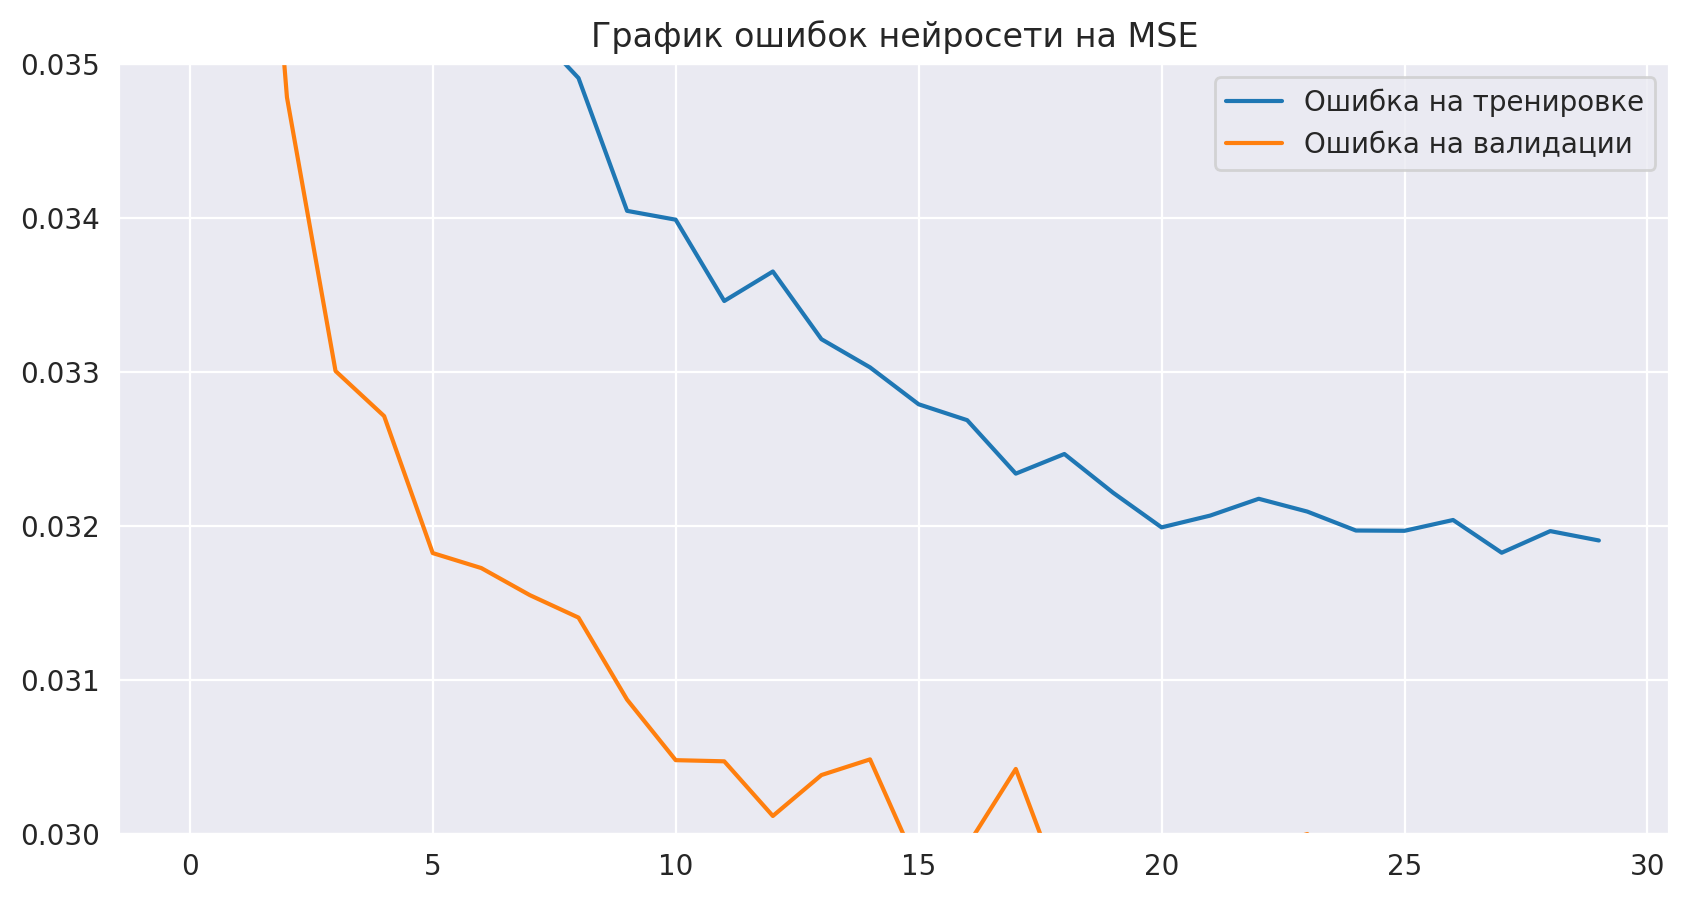

In [27]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(train_losses, label='Ошибка на тренировке')
plt.plot(val_losses, label='Ошибка на валидации')
plt.title('График ошибок нейросети на MSE')
plt.ylim([0.03, 0.035])
plt.legend()

In [28]:
print(f'Реальная ошибка нейросети: {np.sqrt(np.min(val_losses))}')

Реальная ошибка нейросети: 0.17189774567167432


In [98]:
np.argmin(val_losses)

17

# Сохранение параметров модели CatBoost, Xgboost и нейронки

In [42]:
X.head()

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger
0,0.588273,0.816691,3,0,2,0,0.798291,-0.684070,0,0
1,-0.375727,0.258615,3,0,2,2,0.798291,0.963475,0,0
2,-0.054394,0.258615,3,0,2,0,0.798291,0.963475,1,0
3,0.052717,0.705076,0,0,0,0,0.798291,0.963475,0,0
4,-0.268616,0.481846,2,0,0,0,0.798291,0.963475,1,1


In [41]:
y.head()

,target_transformed
0,2.424942
1,2.622919
2,2.560048
3,2.548500
4,2.536914


### Xgboost:
Лучшие гиперпараметры: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}

In [43]:
xgb = XGBRegressor(tree_method='gpu_hist', learning_rate=0.05, max_depth=5, 
                   min_child_weight=4, n_estimators=100, subsample=0.8)


xgb.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [44]:
joblib.dump(xgb, 'XGBoost.joblib')

['XGBoost.joblib']

### CatBoost
Лучшие гиперпараметры: {'learning_rate': 0.05, 'l2_leaf_reg': 9, 'iterations': 500, 'depth': 8}

In [45]:
cat = CatBoostRegressor(task_type='GPU', verbose=0, learning_rate=0.05, l2_leaf_reg=9, 
                        iterations=500, depth=8)

cat.fit(X, y)

In [47]:
cat.save_model('/kaggle/working/CatBoost.bin')

### Нейронка

In [51]:
train_dataset = MyDataset(X, num_columns, categorical_columns, y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [56]:
model = MyModel(len(num_columns), cat_embs).to(device)

In [57]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_losses = []
epochs = 30
for epoch in range(epochs):
    # ТРЕНИРОВКА
    model.train()
    train_loop = tqdm(train_loader)
    train_loss_epoch = 0
    for num_data, cat_data, targets in train_loop:
        num_data = num_data.to(device)
        cat_data = cat_data.to(device)
        targets = targets.to(device)
        
        # прямой проход
        preds = model(num_data, cat_data)
        loss = criterion(preds, targets)
        train_loss_epoch += loss.item()
        

        # обратное распространение
        opt.zero_grad()
        loss.backward()
        opt.step()

    mean_train_loss = train_loss_epoch / len(train_loader)
    train_losses.append(mean_train_loss)
    print(f"Epoch {epoch+1}/{epochs}, train_loss: {mean_train_loss:.4f}")

100%|██████████| 440/440 [00:05<00:00, 74.29it/s]


Epoch 1/30, train_loss: 2.3320


100%|██████████| 440/440 [00:05<00:00, 85.15it/s]


Epoch 2/30, train_loss: 0.2178


100%|██████████| 440/440 [00:05<00:00, 82.78it/s]


Epoch 3/30, train_loss: 0.0883


100%|██████████| 440/440 [00:05<00:00, 82.69it/s]


Epoch 4/30, train_loss: 0.0539


100%|██████████| 440/440 [00:05<00:00, 84.43it/s]


Epoch 5/30, train_loss: 0.0424


100%|██████████| 440/440 [00:05<00:00, 81.85it/s]


Epoch 6/30, train_loss: 0.0386


100%|██████████| 440/440 [00:05<00:00, 84.67it/s]


Epoch 7/30, train_loss: 0.0370


100%|██████████| 440/440 [00:05<00:00, 83.56it/s]


Epoch 8/30, train_loss: 0.0359


100%|██████████| 440/440 [00:05<00:00, 84.03it/s]


Epoch 9/30, train_loss: 0.0354


100%|██████████| 440/440 [00:05<00:00, 84.56it/s]


Epoch 10/30, train_loss: 0.0348


100%|██████████| 440/440 [00:05<00:00, 85.10it/s]


Epoch 11/30, train_loss: 0.0345


100%|██████████| 440/440 [00:05<00:00, 82.58it/s]


Epoch 12/30, train_loss: 0.0342


100%|██████████| 440/440 [00:05<00:00, 85.86it/s]


Epoch 13/30, train_loss: 0.0337


100%|██████████| 440/440 [00:05<00:00, 84.06it/s]


Epoch 14/30, train_loss: 0.0336


100%|██████████| 440/440 [00:05<00:00, 81.48it/s]


Epoch 15/30, train_loss: 0.0331


100%|██████████| 440/440 [00:05<00:00, 83.67it/s]


Epoch 16/30, train_loss: 0.0329


100%|██████████| 440/440 [00:05<00:00, 83.97it/s]


Epoch 17/30, train_loss: 0.0329


100%|██████████| 440/440 [00:05<00:00, 81.68it/s]


Epoch 18/30, train_loss: 0.0327


100%|██████████| 440/440 [00:05<00:00, 83.62it/s]


Epoch 19/30, train_loss: 0.0325


100%|██████████| 440/440 [00:05<00:00, 81.69it/s]


Epoch 20/30, train_loss: 0.0323


100%|██████████| 440/440 [00:05<00:00, 82.81it/s]


Epoch 21/30, train_loss: 0.0325


100%|██████████| 440/440 [00:05<00:00, 83.00it/s]


Epoch 22/30, train_loss: 0.0323


100%|██████████| 440/440 [00:05<00:00, 83.94it/s]


Epoch 23/30, train_loss: 0.0322


100%|██████████| 440/440 [00:05<00:00, 82.50it/s]


Epoch 24/30, train_loss: 0.0321


100%|██████████| 440/440 [00:05<00:00, 83.72it/s]


Epoch 25/30, train_loss: 0.0322


100%|██████████| 440/440 [00:05<00:00, 84.00it/s]


Epoch 26/30, train_loss: 0.0320


100%|██████████| 440/440 [00:05<00:00, 82.23it/s]


Epoch 27/30, train_loss: 0.0319


100%|██████████| 440/440 [00:05<00:00, 83.24it/s]


Epoch 28/30, train_loss: 0.0320


100%|██████████| 440/440 [00:05<00:00, 82.91it/s]


Epoch 29/30, train_loss: 0.0321


100%|██████████| 440/440 [00:05<00:00, 81.88it/s]


Epoch 30/30, train_loss: 0.0318


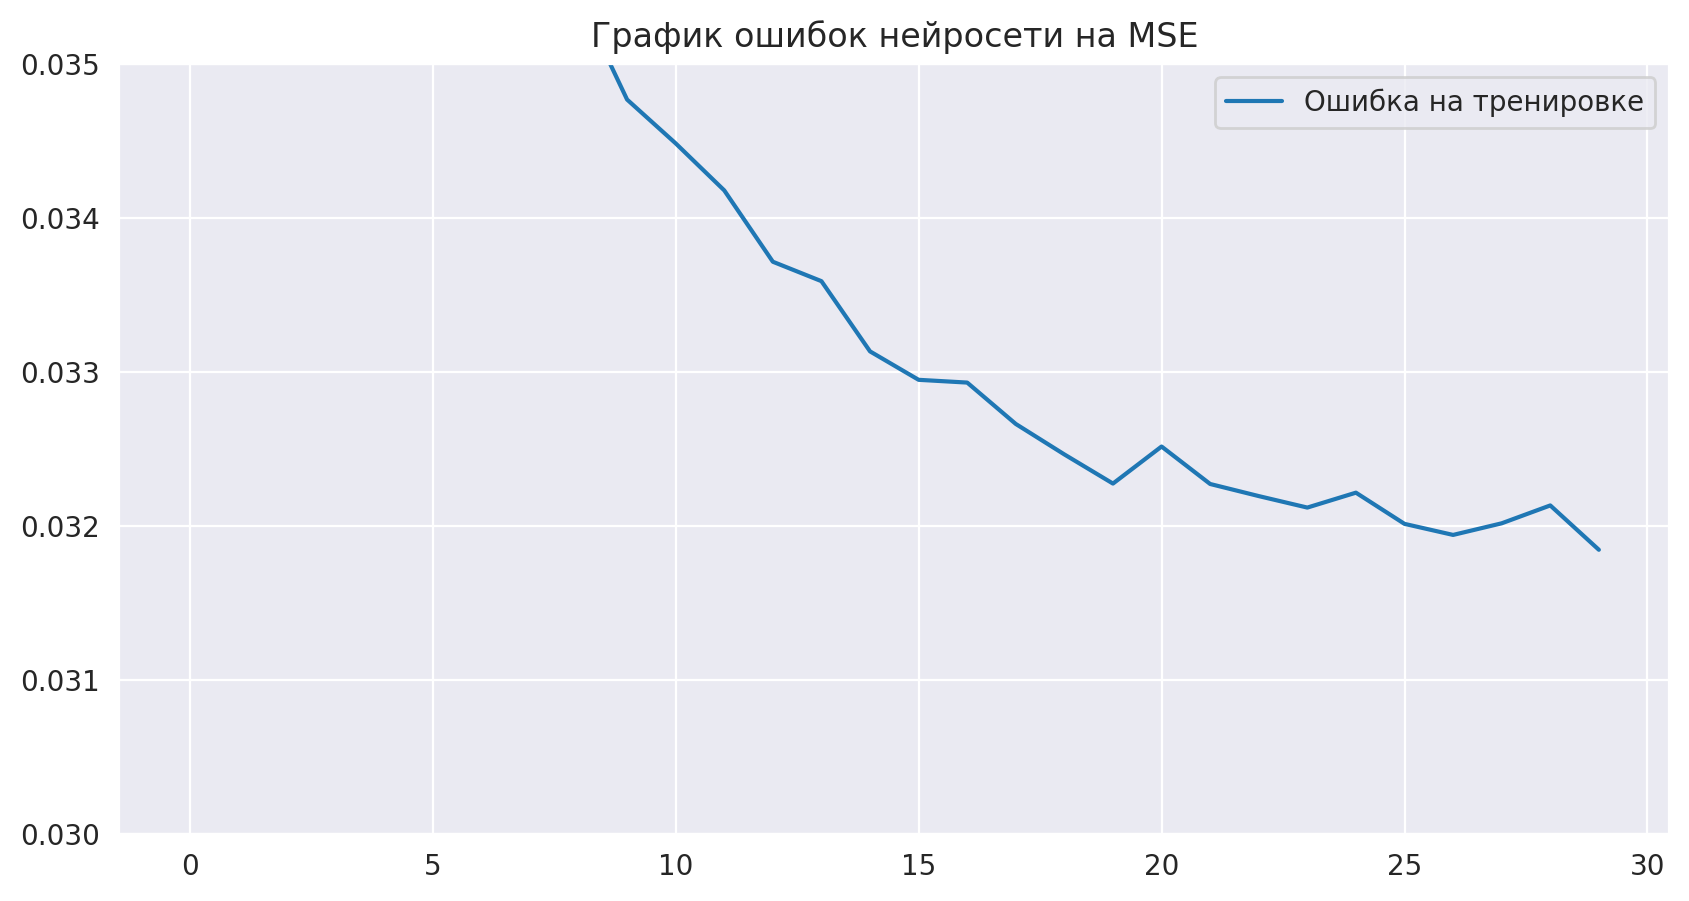

In [61]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(train_losses, label='Ошибка на тренировке')
plt.title('График ошибок нейросети на MSE')
plt.ylim([0.03, 0.035])
plt.legend()

In [63]:
torch.save(model.state_dict(), '/kaggle/working/fully_neuro.pth')

In [64]:
model = MyModel(len(num_columns), cat_embs).to(device)
model.load_state_dict(torch.load('/kaggle/working/fully_neuro.pth', weights_only=True))

<All keys matched successfully>

### Загрузка нейронки и её проверка

In [74]:
train_dataset = MyDataset(pd.DataFrame(X.loc[0]).transpose(), num_columns, 
                          categorical_columns, pd.DataFrame(y.loc[0]).transpose())
val_loader = DataLoader(train_dataset)

In [76]:
model.eval()
y_preds, y_trues = [], []
with torch.no_grad():
    for num_data, cat_data, targets in val_loader:
        num_data = num_data.to(device)
        cat_data = cat_data.to(device)
        targets = targets.to(device)

        # оценка
        preds = model(num_data, cat_data)

        y_preds.append(preds)
        y_trues.append(targets)

In [77]:
y_preds

[tensor([[2.3129]], device='cuda:0')]

In [78]:
y_trues

[tensor([[2.4249]], device='cuda:0')]